## Necessary imports

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from neuralyzer.datasets import FlatPatchDataset, load_image

## The Perception layer

In [16]:
class Perception(object):
    """
    A class that represents a perception model.
    """
    def __init__(
        self,
        n_percepts: int,
        size: int,
        channels: int,
        low: float = 0.0,
        high: float = 1.0
    ):
        """
        Initializes a perception model.

        Args:
            n_percepts: The number of percepts.
            size: The size of the percepts.
            channels: The number of channels of the percepts.
            low: The lower bound of the uniform distribution used to initialize the weights.
            high: The upper bound of the uniform distribution used to initialize the weights.
        """
        self.n_percepts = n_percepts
        self.size = size
        self.channels = channels
        self.percepts = torch.nn.Linear(
            in_features=size * size * channels,
            out_features=n_percepts,
            bias=False
        )
        torch.nn.init.uniform_(self.percepts.weight, low, high)
        self.conv = torch.nn.Conv2d(
            in_channels=self.channels,
            out_channels=self.n_percepts,
            kernel_size=self.size,
            stride=1,
            padding=0,
            bias=False
        )
    
    def get_patterns(self) -> torch.Tensor:
        """
        Returns the patterns of the perception model.
        
        Returns:
            The patterns. Shape: (n_percepts, channels, size, size)
        """
        patterns_ = self.percepts.weight.reshape(
            self.n_percepts,
            self.channels,
            self.size,
            self.size
        )
        return patterns_
    
    def get_conv_kernels(self) -> torch.Tensor:
        """
        Returns the kernels of the perception model.
        
        Returns:
            The kernels. Shape: (n_percepts, channels, size, size)
        """
        kernels_ = self.get_patterns()
        # mirror kernels
        kernels_ = torch.flip(kernels_, [2, 3])
        return kernels_
    
    def _process_image(
        self,
        images: torch.Tensor
    ) -> torch.Tensor:
        """
        Computes the feature maps of the images.
        
        Args:
            images: The images. Shape: (batch_size, channels, height, width)
            
        Returns:
            The feature maps. Shape: (batch_size, n_percepts, height, width)
        """
        with torch.no_grad():
            self.conv.weight.data = self.get_conv_kernels()
            output = self.conv(images)
        return output
    
    def _process_patches(
        self,
        patches: torch.Tensor
    ) -> torch.Tensor:
        """
        Computes the percepts of the patches.
        
        Args:
            patches: The patches. Shape: (batch_size, n_patches, channels, size, size)
            
        Returns:
            The percepts. Shape: (batch_size, n_patches, n_percepts)
        """
        with torch.no_grad():
            output = self.percepts(patches)
        return output
    
    @property
    def weight(self) -> torch.Tensor:
        """
        Returns the weights of the perception model.
        
        Returns:
            The weights. Shape: (n_percepts, size * size * channels)
        """
        return self.percepts.weight
    
    def __call__(
        self,
        inputs: torch.Tensor,
        mode: str = "patches"
    ) -> torch.Tensor:
        """
        Computes the percepts of the patches.
        
        Args:
            patches: The patches.
            
        Returns:
            The percepts.
        """
        if mode == "patches":
            return self._process_patches(inputs)
        if mode == "images":
            return self._process_image(inputs)
        raise ValueError("Invalid mode.")

## Tests

In [17]:

n_percepts = 16
patch_size = 5
stride = 1
learning_rate = 0.05
batch_size = 16
init_low = 0
init_high = 1
n_iterations = 1000000
image_file = "/Users/arnaudabreu/Downloads/lenna.png"

In [18]:
perception = Perception(
    n_percepts=n_percepts,
    size=patch_size,
    channels=1,
    low=init_low,
    high=init_high
)

In [19]:
dataset = FlatPatchDataset(
    patch_size=patch_size,
    stride=stride,
    batch_size=batch_size
)
loader = dataset.load(
    img_path=image_file,
    gray=True
)

In [20]:
def temperature_softmax(
    logits: torch.Tensor,
    temperature: float = 1.0
):
    """
    Apply a softmax function to the logits with a temperature.
    
    Args:
        logits (torch.Tensor): the input logits
        temperature (float): the temperature to apply to the logits
        
    Returns:
        torch.Tensor: the output of the softmax function
    """
    return torch.nn.functional.softmax(logits/temperature, dim=1)

def winners_take_all(logits):
    """
    Apply the winners-take-all function to the logits.
    
    Args:
        logits (torch.Tensor): the input logits
        
    Returns:
        torch.Tensor: the output of the winners-take-all function (0 for all values except the maximum)
    """
    logit_max = logits.max(dim=1, keepdim=True).values
    wta = torch.where(logits < logit_max, torch.zeros_like(logits), logits)
    return wta

In [21]:
def oja_update_rule(
    weights: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    learning_rate: float
):
    """
    Compute new weights using the Oja update rule.
    
    Args:
        weights (torch.Tensor): The weights of the model with shape (out_features, in_features).
        x (torch.Tensor): The input data with shape (batch, in_features).
        y (torch.Tensor): The output data with shape (batch, out_features).
        learning_rate (float): The learning rate.
    """
    # add a feature dimension to x (to match the weights dimensions)
    inputs = x.unsqueeze(1) # (batch, 1, in_features)
    # add a feature dimension to y (to match the weights dimensions)
    outputs = y.unsqueeze(-1) # (batch, out_features, 1)
    # add a batch dimension to the weights (to match the inputs dimensions)
    synapses = weights.unsqueeze(0) # (1, out_features, in_features)
    # logits to probabilities
    z = temperature_softmax(y) # (batch, out_features)
    # set non-maximum values to zero in z (anti-Hebbian plasticity)
    winners = winners_take_all(z) # (batch, out_features)
    # add a feature dimension to z (to match the weights dimensions)
    winners = winners.unsqueeze(-1) # (batch, out_features, 1)
    # apply the Oja update rule
    # synaptic activity. Synapses will learn if the output is active
    synaptic_activity = synapses * outputs # (batch, out_features, in_features)
    # hebbian error. Active neurons will strengthen the affinity between the inputs and their synaptic weights
    error = inputs - synaptic_activity # (batch, out_features, in_features)
    delta = learning_rate * winners * error # (batch, out_features, in_features)
    updates = synapses + delta # (batch, out_features, in_features
    # average the updates over the batch
    updated_synapses = updates.mean(dim=0) # (out_features, in_features)
    return updated_synapses

In [22]:
for idx, batch in enumerate(loader):
    if idx > n_iterations:
        break
    x = batch["image"]
    y = perception(x)
    with torch.no_grad():
        w = perception.weight
        w_updated = oja_update_rule(w, x, y, learning_rate)
        perception.weight.data = w_updated

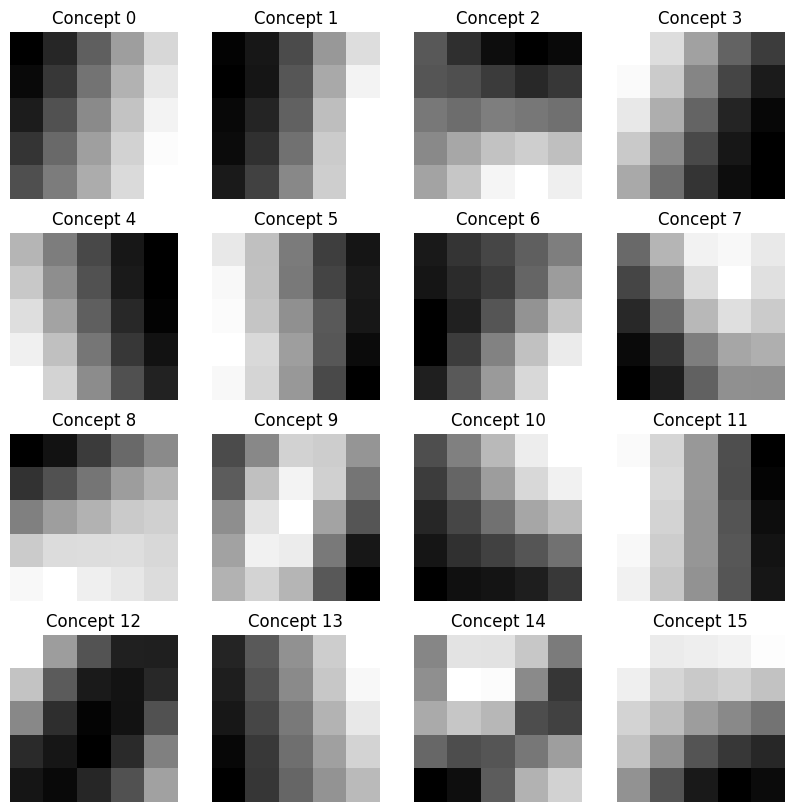

In [23]:
n_size = int(np.sqrt(n_percepts))
fig, axs = plt.subplots(n_size, n_size, figsize=(10, 10))
patterns = perception.get_patterns()
patterns = patterns.squeeze(1).detach().numpy()
for i in range(n_percepts):
    ax = axs[i//n_size, i%n_size]
    ax.imshow(patterns[i], cmap="gray")
    ax.axis("off")
    ax.set_title(f"Concept {i}")

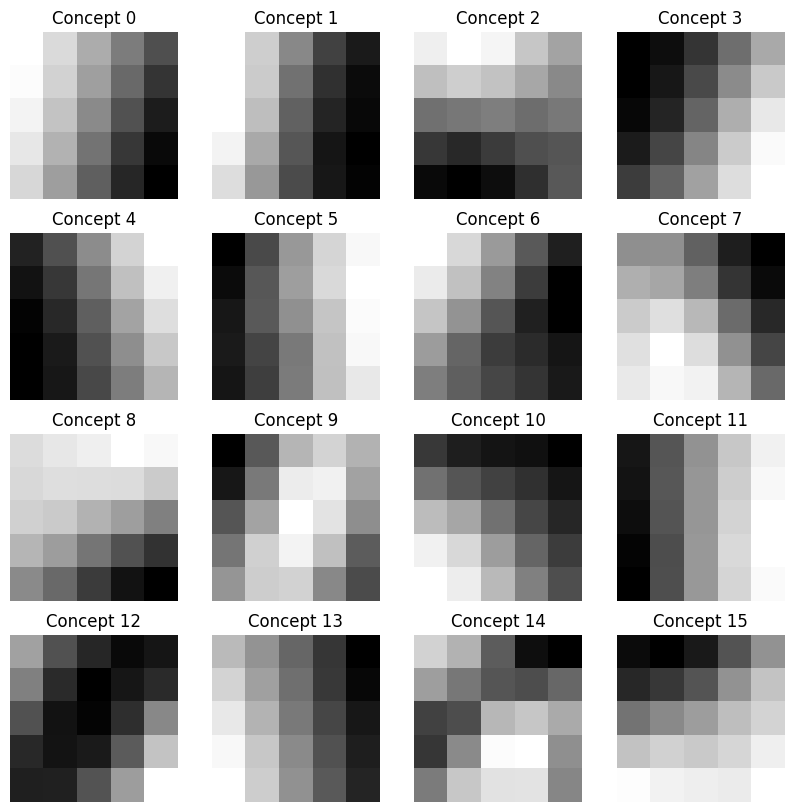

In [24]:
n_size = int(np.sqrt(n_percepts))
fig, axs = plt.subplots(n_size, n_size, figsize=(10, 10))
kernels = perception.get_conv_kernels()
kernels = kernels.squeeze(1).detach().numpy()
for i in range(n_percepts):
    ax = axs[i//n_size, i%n_size]
    ax.imshow(kernels[i], cmap="gray")
    ax.axis("off")
    ax.set_title(f"Concept {i}")

Output shape: torch.Size([1, 16, 508, 508])


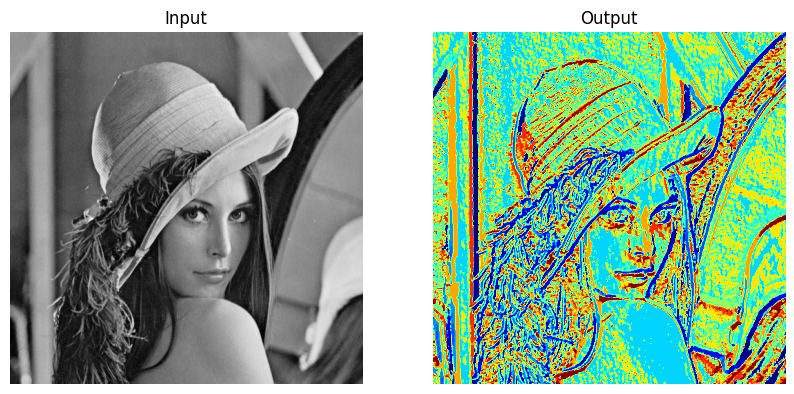

In [25]:
# load an image
image = load_image(image_file, gray=True)
# put the image in a tensor
image_ = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
# apply the convolution
output_ = perception(image_, mode="images")
print(f"Output shape: {output_.shape}")
# apply the softmax to the output
probas_ = temperature_softmax(output_)
# apply argmax to get the most activated concept
concept_map_ = torch.argmax(probas_, dim=1)
# plot the input and output
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap="gray")
axs[0].axis("off")
axs[0].set_title("Input")
axs[1].imshow(concept_map_.squeeze().detach().numpy(), cmap="jet")
axs[1].axis("off")
axs[1].set_title("Output")
plt.show()

Concept probabilities shape: torch.Size([1, 508, 508])


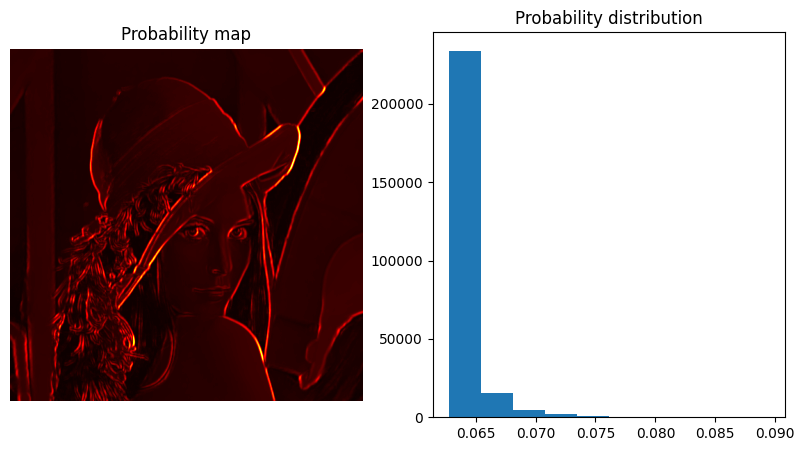

In [26]:
# check the probability of the output
concept_probas_ = torch.max(probas_, dim=1).values
print(f"Concept probabilities shape: {concept_probas_.shape}")
# plot the probability map and the distribution of the probabilities
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(concept_probas_.squeeze().detach().numpy(), cmap="hot")
axs[0].axis("off")
axs[0].set_title("Probability map")
axs[1].hist(concept_probas_.squeeze().detach().numpy().flatten())
axs[1].set_title("Probability distribution")
plt.show()

In [27]:
probas = probas_.squeeze().detach().numpy()
probas.shape

(16, 508, 508)

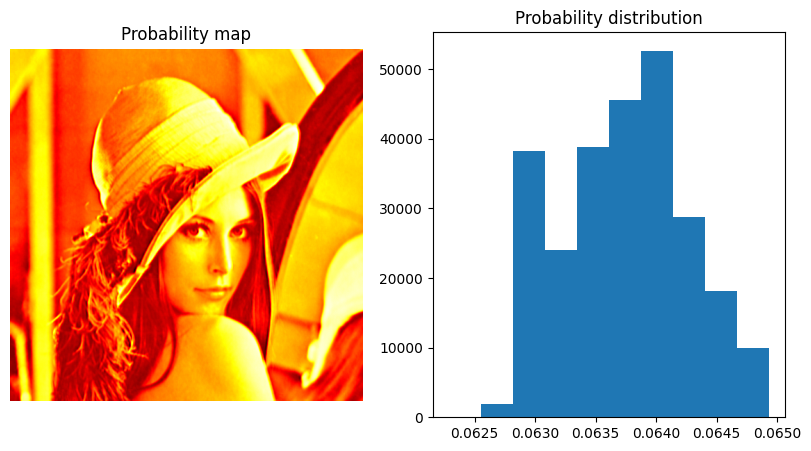

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(probas[10], cmap="hot")
axs[0].axis("off")
axs[0].set_title("Probability map")
axs[1].hist(probas[10].flatten())
axs[1].set_title("Probability distribution")
plt.show()